In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d
import bresenham as bham
import bobsegutils as bsu

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from descartes.patch import PolygonPatch

from scipy.interpolate import griddata

from scipy.stats.stats import pearsonr
from scipy.stats.stats import kendalltau
from scipy import ndimage

from glob import glob
from skimage.measure import regionprops
from skimage.segmentation import find_boundaries
from scipy import spatial

from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse
from matplotlib.patches import Polygon
from scipy.ndimage.morphology import binary_fill_holes, binary_closing

Populating the interactive namespace from numpy and matplotlib


/Users/prakash/anaconda/envs/Py35forBobSeg/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Loading and preparing data

```stack``` is the original stack as it is loaded from file<br>
```segchannel``` is the membrane channel only (needs to be taken out of loaded stack)<br>
```flowchannel``` is the myosin channel only<br>
```segchannel_smooth``` is the ```segchannel``` after gaussian smoothing<br>
(note: the less the better for the gradientimage)<br>
```gradientimage``` should be used for segmentation if some of the cell boundary (membrane) is barely visible<br>

In [2]:
fn_membrane = '/Users/prakash/Downloads/MAX_20190430_LP823-zyx-1ko_05-01-e1_Membrane-1.tif' # Path to normalized membrane image
fn_myosin   = '/Users/prakash/Downloads/MAX_20190430_LP823-zyx-1ko_05-01-e1_Myosin-1.tif' # Path to myosin image

segchannel = imread(fn_membrane)
flowchannel = imread(fn_myosin)

sigma = [0.,2,2]
segchannel_smooth = gaussian(segchannel,sigma)
flowchannel_smooth = gaussian(flowchannel,[0.,1,1])

gradientimage = segchannel_smooth

T = len(segchannel)-1  # number of time-points (last one is superfluous)
tempres_factor = int(len(flowchannel)/T)
print(tempres_factor)

if len(flowchannel)%T != 0:
    raise 'Tempres problem: please check imported data!'
else:
    print ('Tempres factor: %s'%tempres_factor)

print('Shape of membrane channel :', segchannel.shape)
print('Shape of flow channel:', flowchannel.shape)

6
Tempres factor: 6
Shape of membrane channel : (11, 581, 408)
Shape of flow channel: (60, 581, 408)


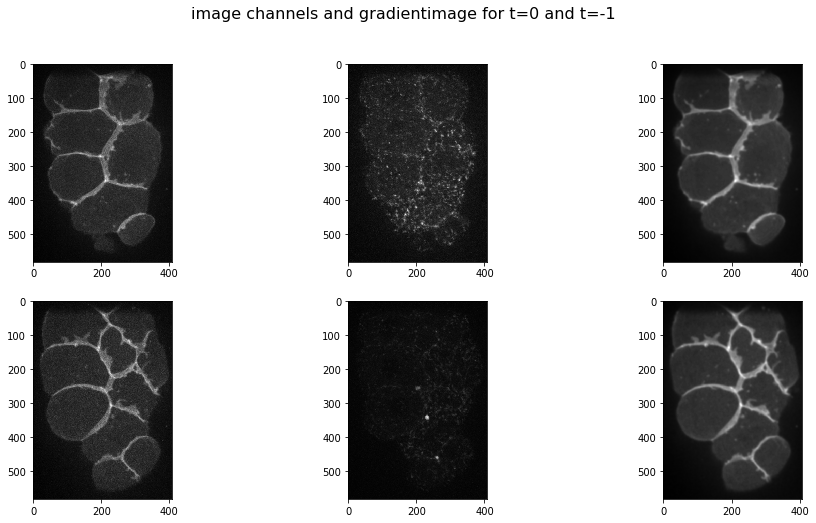

In [3]:
pylab.rcParams['figure.figsize'] = (16, 8)
fig = plt.figure()
fig.suptitle('image channels and gradientimage for t=0 and t=-1', fontsize=16)
ax = fig.add_subplot(231)
ax.imshow(segchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(232)
ax.imshow(flowchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(233)
ax.imshow(gradientimage[0], plt.get_cmap('gray'))
ax = fig.add_subplot(234)
ax.imshow(segchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(235)
ax.imshow(flowchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(236)
ax.imshow(gradientimage[-1], plt.get_cmap('gray'))
# fig.tight_layout()

# Cell segmentation and postprocessing

Load Labkit segmented images. The only consideration is that the segmentation should have closed(connected) components for Ea and Ep cells (or any other cell of interest). The segmented image should have 0 as value for pixels belonging to cell and 1 for pixels belonging to membrane and background

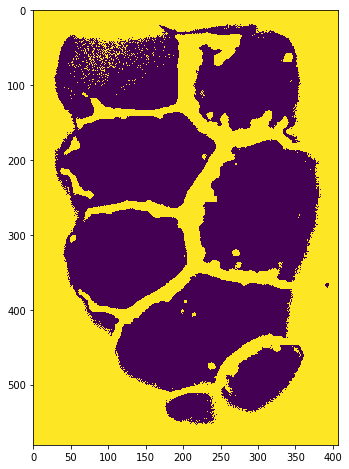

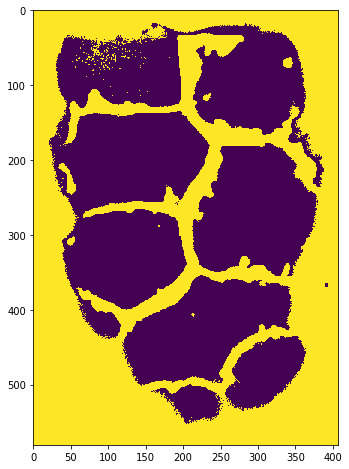

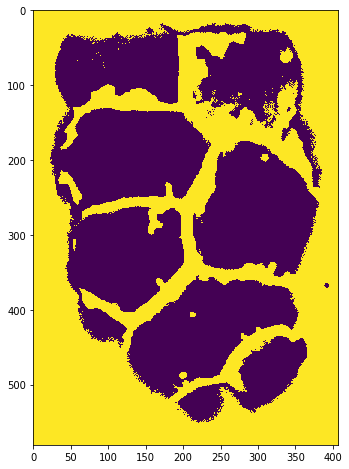

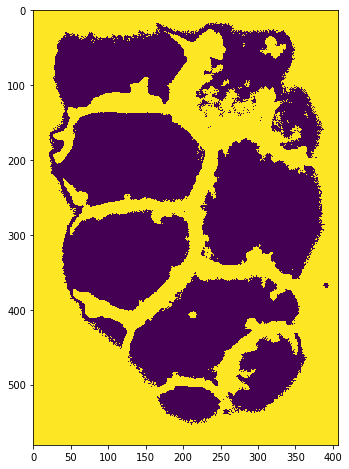

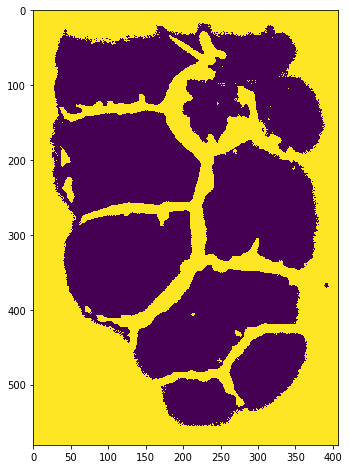

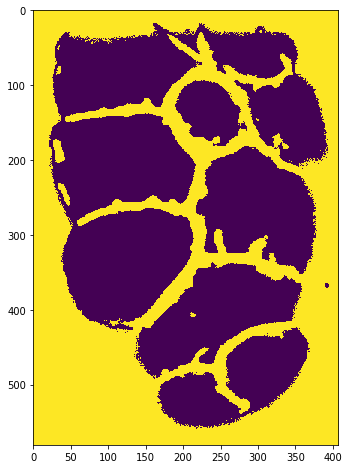

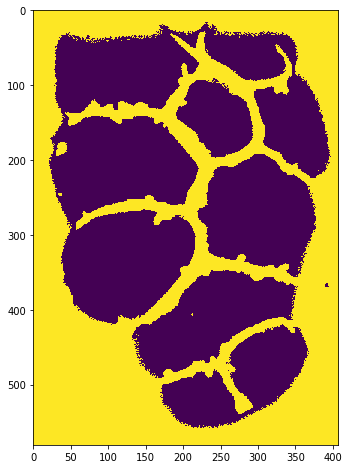

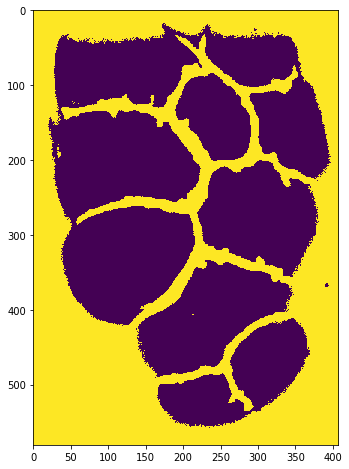

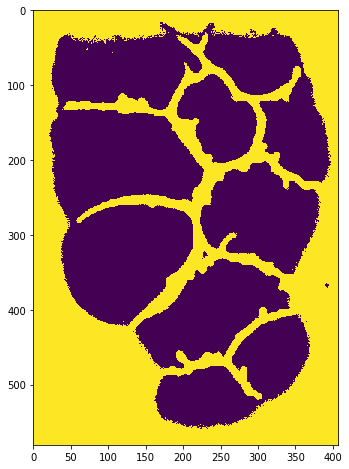

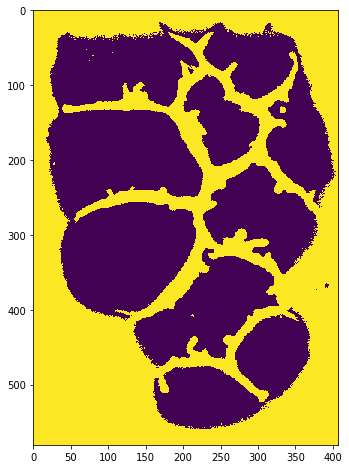

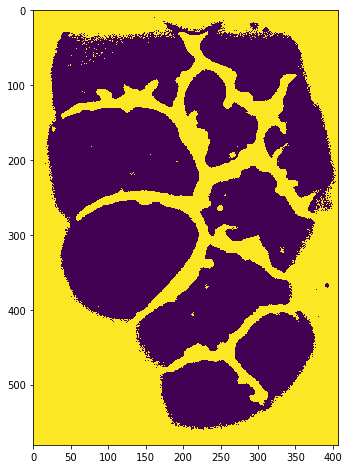

In [4]:
edited = imread('/Users/prakash/Downloads/MAX_20190430_LP823-zyx-1ko_05-01-e1_Membrane_label.tif') # expects only connected components, with cell 0 and membrane and background 1
curated = 1 - edited
curated = curated.astype(int8)
curated = binary_fill_holes(curated)
curated = 1 - curated
curated = binary_fill_holes(curated)



for k in range(curated.shape[0]):
    plt.imshow(curated[k])
    plt.show()

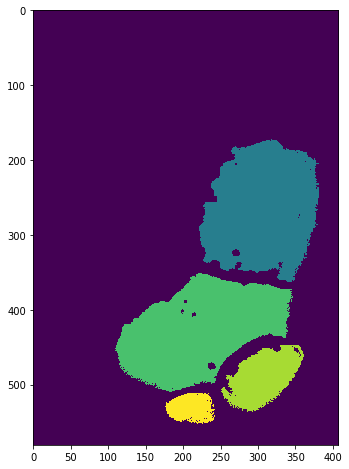

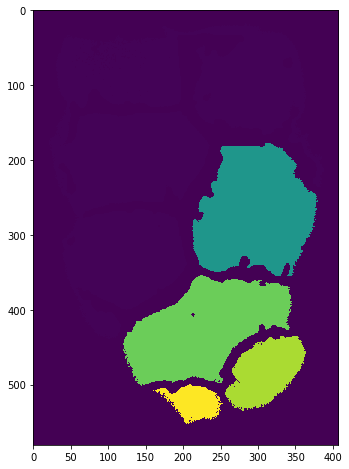

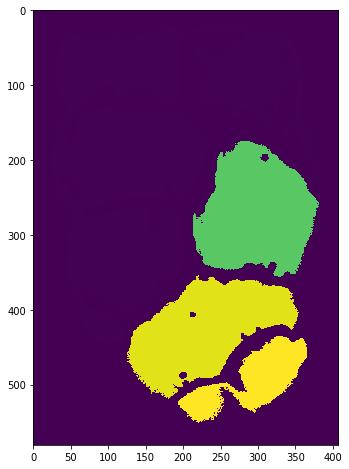

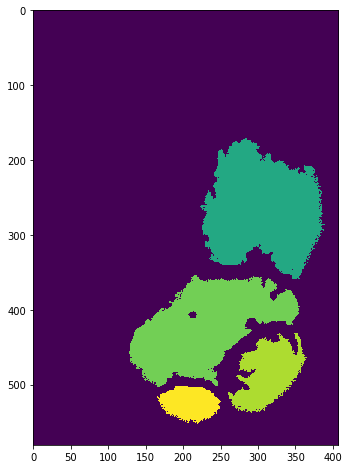

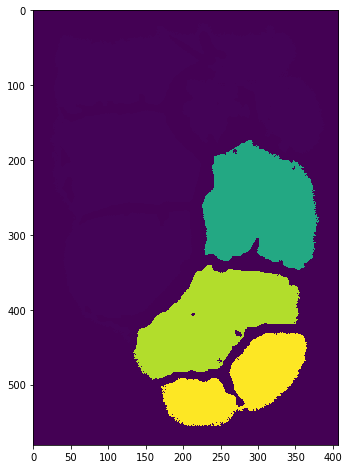

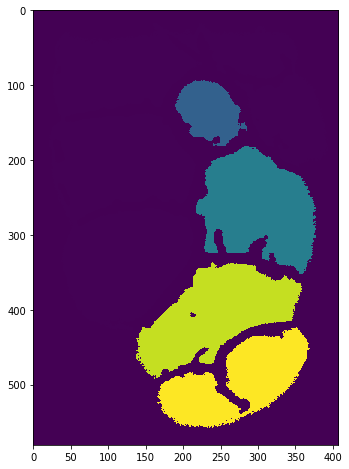

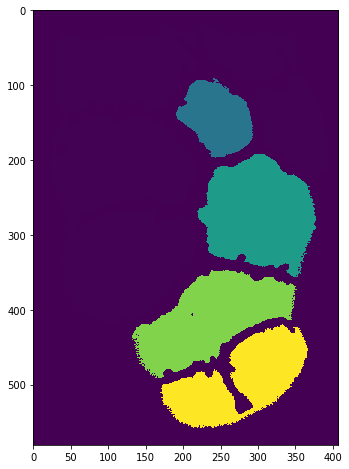

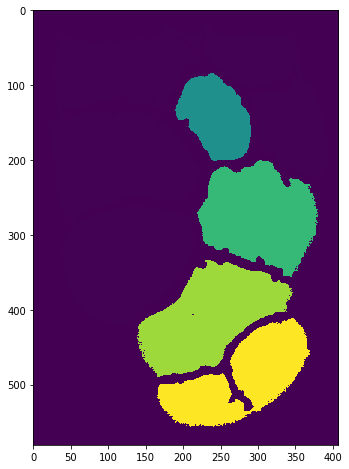

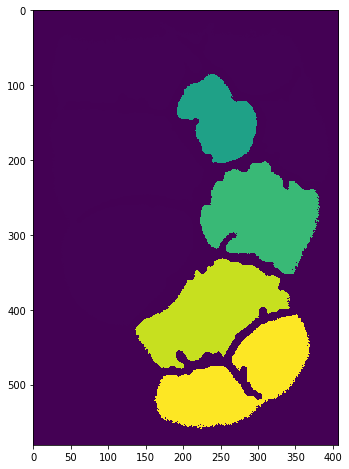

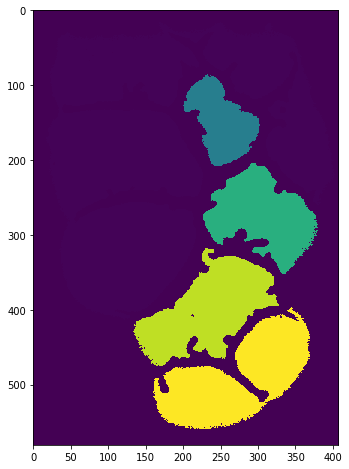

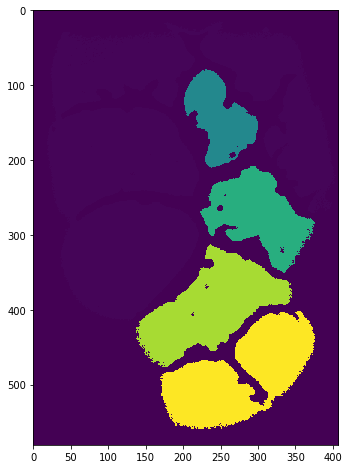

In [5]:
label_images_per_frame = []
for i in range(0,curated.shape[0]):
    curated[i] = 1-curated[i]
    labels_per_frame, _ = ndimage.label(curated[i])
    label_size = []
    label_ids = []
    regions = regionprops(labels_per_frame)
    for props in regions:
        label_ids.append(props.label)
        label_size.append(props.area)
        for label_number in range(0, len(label_ids)): # Filtering out components smaller than 1000 pixels area
            if label_size[label_number] < 1000 :
                labels_per_frame[ labels_per_frame == label_ids[label_number] ] = 0
    
    label_images_per_frame.append(labels_per_frame)
    plt.imshow(labels_per_frame)
    plt.show()
#     imsave('/Users/prakash/Desktop/Bob_Segmentation/new/test_label'+str(i)+'.tif', labels_per_frame)

In [6]:
data = Data3d( gradientimage, pixelsize=(1.,1.), silent=True )
objects = []
seeds = []

Add the identity(name) and approximate centroids of the cells of interest below. 

In [7]:
cell_Ea = data.init_object("Ea")
objects.append(cell_Ea)
Ea_centroid_this_frame = (419, 228) # x, y reversed for kdtree
seeds.append(Ea_centroid_this_frame)

In [8]:
cell_Ep = data.init_object("Ep")
objects.append(cell_Ep)
Ep_centroid_this_frame = (280, 293) # x, y reversed for kdtree
seeds.append(Ep_centroid_this_frame)

The cell below extracts the coordianets of all the pixels on the membrane of the cells of interest

In [9]:
unsampled_surface_coords = {}
query_centroids = {}
queried_labels = {}

for obj in range(len(objects)):
    
    seed = seeds[obj]
    object_centroids = []
    unsampled_surface_coords_per_object = []
    queried_labels_per_object = []
    
    for frame in range(0, curated.shape[0]):

        all_centroids_per_frame = []
        label_per_frame = []
        regions = regionprops(label_images_per_frame[frame])
        for props in regions:
            all_centroids_per_frame.append(props.centroid)
            label_per_frame.append(props.label)
        distance,index = spatial.KDTree(all_centroids_per_frame).query(seed)
        label_boundaries_per_frame = find_boundaries(label_images_per_frame[frame] == label_per_frame[index])
        surface_coord_per_frame = np.column_stack(np.where(label_boundaries_per_frame))
        surface_coord_per_frame = surface_coord_per_frame.tolist()
        surface_coord_per_frame = [tuple(l) for l in surface_coord_per_frame]

        unsampled_surface_coords_per_object.append(surface_coord_per_frame)

        seed = all_centroids_per_frame[index]
        
        object_centroids.append(seed)
        queried_labels_per_object.append(label_per_frame[index])
    
    
    unsampled_surface_coords[obj] = unsampled_surface_coords_per_object
    query_centroids[obj] = object_centroids
    queried_labels[obj] = queried_labels_per_object

In [10]:
queried_labels # Just fo sanity check

{0: [197, 140, 243, 325, 156, 136, 111, 132, 120, 112, 253],
 1: [119, 95, 189, 249, 106, 64, 75, 104, 89, 78, 182]}

unsampled_surface_coords is inverted in x,y

In [11]:
def sample_circle( n=18 ):
    '''
        Returns n many points on the unit circle (equally spaced).
    '''
    points = np.zeros([n,2])
    for i in range(n):
        angle = 2*math.pi * i/float(n)
        x = math.cos(angle)
        y = math.sin(angle)
        # print angle, x, y
        points[i] = [x,y]
        
    return points

Specify the parameters of Spider leg below

In [12]:
num_columns = 72
col_vectors = sample_circle( num_columns )
min_radius = [(5,5), (5,5)]
max_radius = [(150,150), (100, 100)]

In [13]:
def get_coords(obj_id):
    
    '''
        Returns coordinates of points on the columns for the queried object
    '''
    sampled_surface_coords = {}
    for t in range(curated.shape[0]):
        surface_coords_per_time = []
        surface_coords_per_column = []
        for i in range(num_columns):
            from_x = int(query_centroids[obj_id][t][1] + col_vectors[i,0]*min_radius[obj_id][0])
            from_y = int(query_centroids[obj_id][t][0] + col_vectors[i,1]*min_radius[obj_id][1])
            to_x = int(query_centroids[obj_id][t][1] + col_vectors[i,0]*max_radius[obj_id][0])
            to_y = int(query_centroids[obj_id][t][0] + col_vectors[i,1]*max_radius[obj_id][1])
            coords_per_column = bham.bresenhamline(np.array([[from_x, from_y]]), np.array([[to_x, to_y]]))
            num_pixels = len(coords_per_column)
            coords_per_column = coords_per_column.tolist()
            coords_per_column = [tuple(l) for l in coords_per_column]
            interior_coords = []
            for pt in (coords_per_column):
                if(label_images_per_frame[t][pt[1]][pt[0]] == queried_labels[obj_id][t]):
                    interior_coords.append(pt)
            
            if(interior_coords == []):
                print('Empty!, please recenter the centroid of cell ',obj_id ,' at times t >=', t)
            surface_coords_per_column.append(interior_coords[-1])
            
        sampled_surface_coords[t] = surface_coords_per_column
        
    return sampled_surface_coords

The cell below should be uncommented and run only if the cell above thows errors. In cse of errors, adjust the centroid of the specified cell(s) at the specified time points memntioned in the error message above.

In [14]:
# query_centroids[0][9] = (444, 252)
# query_centroids[0][10] = (449, 254)

In [15]:
sampled_coords = {} #key: object_id, 
# value: dictionary with key: time, value: list of lists (coordinate matches along column with segmentation)
#Inner list is matches along each column id 

for ob in range(len(objects)):
    
    sampled_coords[ob] = get_coords(ob)

In [16]:
def plot_result( obj, frame, ax, imagedata=None ):
    if imagedata is None:
        ax.imshow(images[frame], plt.get_cmap('gray'))
    else:
        ax.imshow(imagedata[frame], plt.get_cmap('gray'))

    for oid in range(len(objects)):
        patches = [] # collects patches to be plotted
        surface = sampled_coords[obj][frame]
        polygon = Polygon(surface, True)
        patches.append(polygon)
        a = 0.2 + (float(oid)/len(objects))*0.6
        p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=a, color='green')
        ax.add_collection(p)

The cell below plots the results of segmentation as obtained by combining Labkit based segmentation and Spider legs as a means for sanity check

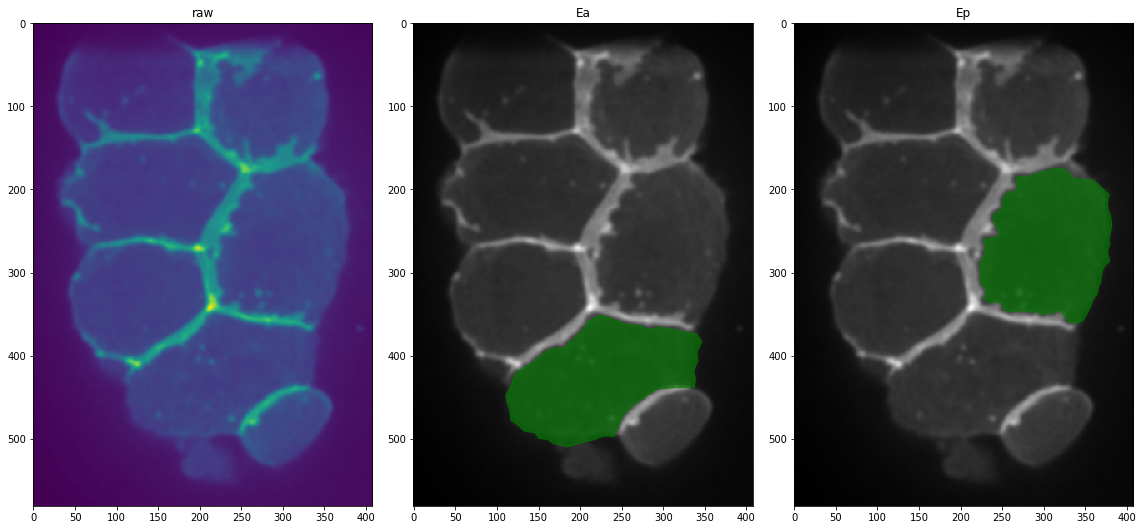

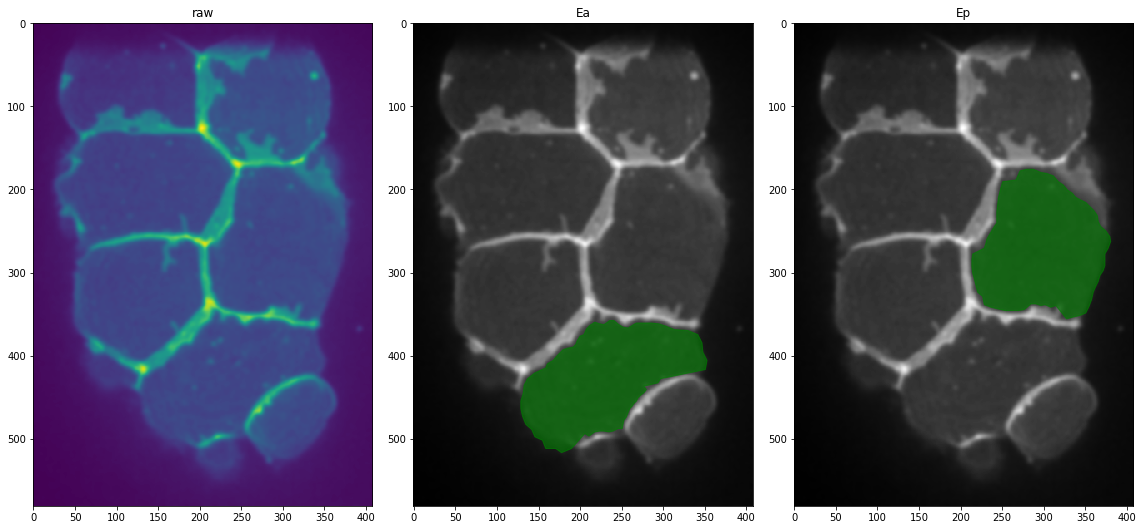

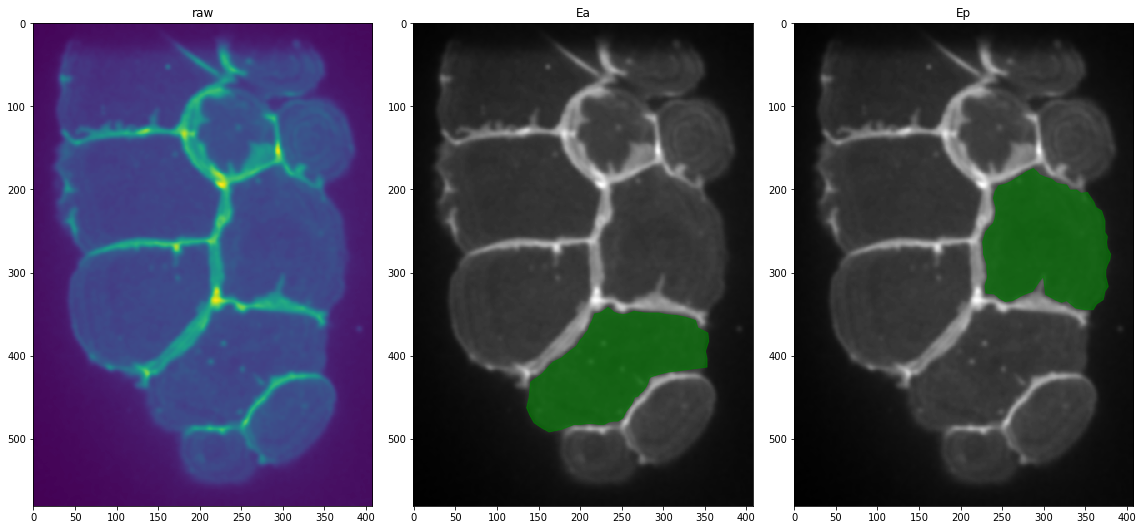

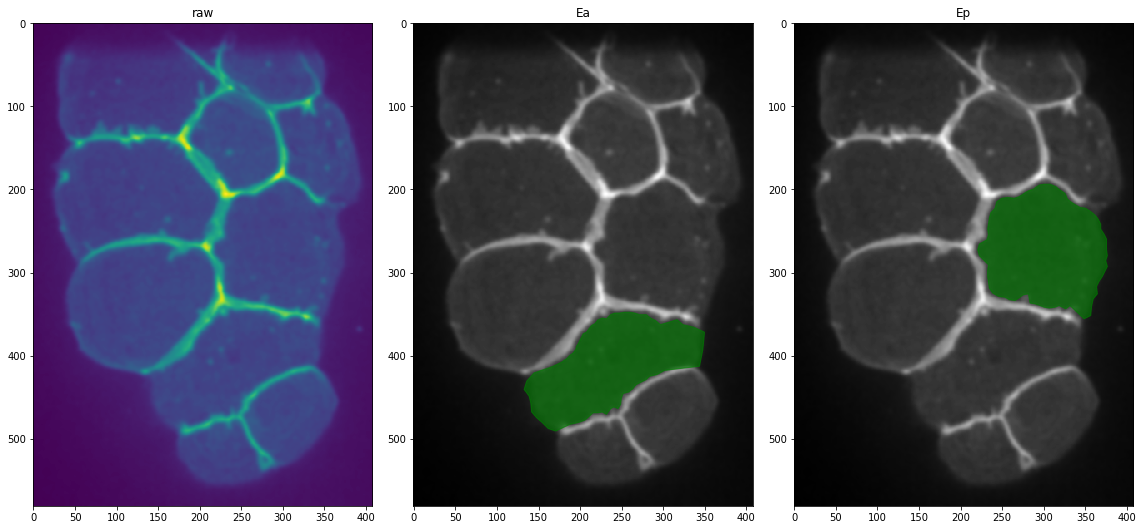

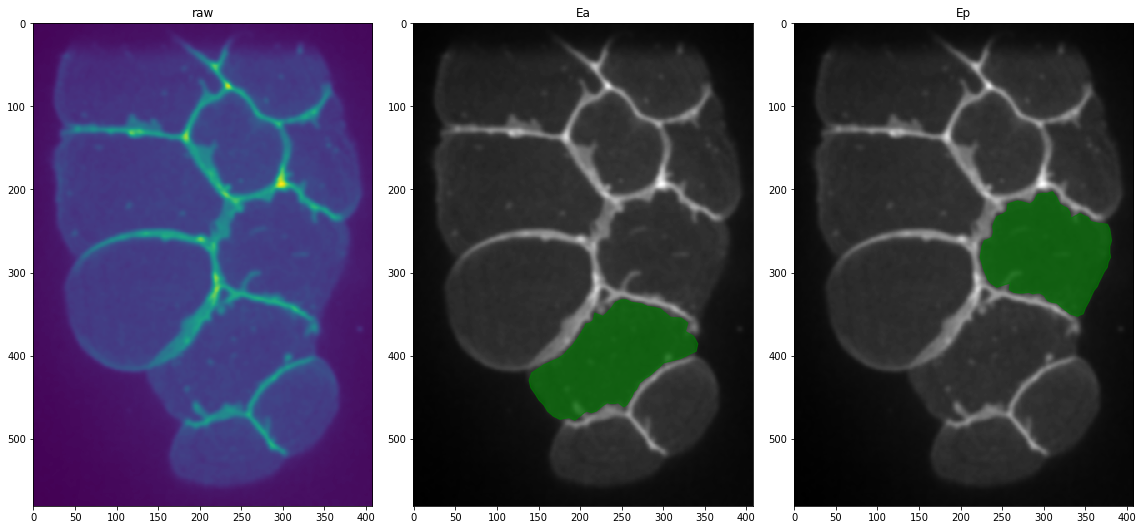

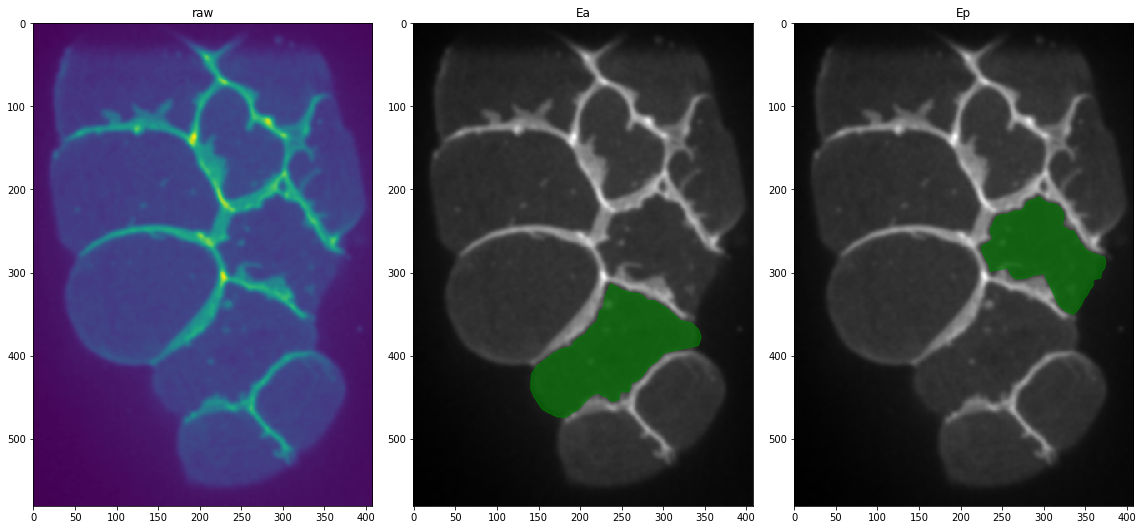

In [17]:
pylab.rcParams['figure.figsize'] = (16, 10)
for frame in range(0,len(data.images),int(len(data.images)/5)):
    fig = plt.figure()
    ax = plt.subplot(131)
    ax.set_title('raw')
    ax.imshow( segchannel_smooth[frame] )  
    ax = plt.subplot(132)
    ax.set_title('Ea')
    plot_result( 0, frame, ax, segchannel_smooth )  
    ax = plt.subplot(133)
    ax.set_title('Ep')
    plot_result( 1, frame, ax, segchannel_smooth )
    fig.tight_layout()

# Flow computation (taking higher frame-rate into account)

In [18]:
flows = imread('/Users/prakash/Downloads/MAX_20190430_LP823-zyx-1ko_05-01-e1_Myosin_flow.tif') # Load the flow image stack saved from GUI
print(flows.shape)

(120, 581, 408)


In [19]:
flow_x = []
flow_y = []
for i in range(0,flows.shape[0],2):
    singleflow_x = flows[i]
    singleflow_y = flows[i+1]
    flow_x.append(singleflow_x)
    flow_y.append(singleflow_y)

flow_x = np.array(flow_x)
flow_y = np.array(flow_y)

In [20]:
avg_flow_x = bsu.flow_merge_frames(flow_x, tempres_factor)
avg_flow_y = bsu.flow_merge_frames(flow_y, tempres_factor)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

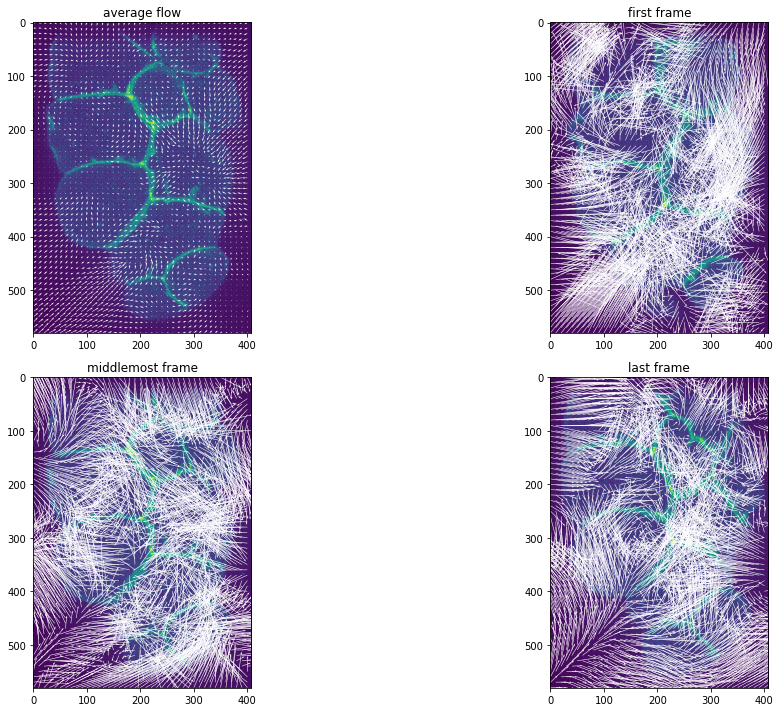

In [21]:
pylab.rcParams['figure.figsize'] = (18, 10)
fig = plt.figure()

y,x = np.mgrid[0:shape(segchannel)[1]:1, 0:shape(segchannel)[2]:1]
skip = (slice(None, None, 10), slice(None, None, 10))

ax = plt.subplot(221)
ax.set_title('average flow')
ax.imshow(segchannel[int(len(segchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],total_avg_flow_x[skip],-total_avg_flow_y[skip], color='w', scale = 50)

ax = plt.subplot(222)
ax.set_title('first frame')
ax.imshow(segchannel[0])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[0][skip],-avg_flow_y[0][skip], color='w', scale=50)

ax = plt.subplot(223)
ax.set_title('middlemost frame')
ax.imshow(segchannel[int(len(segchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[int(len(segchannel)/2)][skip],-avg_flow_y[int(len(segchannel)/2)][skip], color='w', scale=50)

ax = plt.subplot(224)
ax.set_title('last frame')
ax.imshow(segchannel[-1])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[-1][skip],-avg_flow_y[-1][skip], color='w', scale=50)

fig.tight_layout()
fig.savefig('test.pdf',dpi=300)

# Flow data crunching...

In [22]:
annulus_outer_factor = .9 # The outer annulus as fraction of membarnbe segmentation
annulus_inner_factor = .7 # The inner annulus as fraction of membarnbe segmentation

In [23]:
def shrink_polygone(coords, center, shrinkage_factor):
    
    ''' returns coordinates of shrunk polygone
        coords: list of tuples
        shrinkage_factor: between 0 and 1; 1 being no shrinkage
    '''
    xs = [i[0] for i in coords]
    ys = [i[1] for i in coords]
    x_center = center[1]
    y_center = center[0]
    # shrink figure
    new_xs = [(i - x_center) * shrinkage_factor + x_center for i in xs]
    new_ys = [(i - y_center) * shrinkage_factor + y_center for i in ys]
    # create list of new coordinates
    new_coords = zip(new_xs, new_ys)
    new_coords = list(new_coords)
    return new_coords

In [24]:
def get_polygone_points( obj, frame, scaling_factor=1.0 ):
    """
    scaling_factor: scales the polygone by the given factor, 1.0 by default. 
    calibration: 2-tupel of pixel size multipliers
    """
    unscaled_surface_coords = sampled_coords[obj][frame]
    center = query_centroids[obj][frame]
    surface_coords = shrink_polygone(unscaled_surface_coords, center, scaling_factor)
    return surface_coords

In [25]:
membrane_polygones_per_object = []
annulus_outer_polygones_per_object = []
annulus_middle_polygones_per_object = []
annulus_inner_polygones_per_object = []
for obj in objects:
    membrane_polygones = []
    annulus_outer_polygones = []
    annulus_middle_polygones = []
    annulus_inner_polygones = []
    for t in range(T+1):
        
        membrane_polygones.append( get_polygone_points(obj, t, 1) )
        annulus_outer_polygones.append( get_polygone_points(obj, t,annulus_outer_factor) )
        annulus_middle_polygones.append( get_polygone_points(obj, t,(annulus_outer_factor+annulus_inner_factor)/2) )
        annulus_inner_polygones.append( get_polygone_points(obj, t,annulus_inner_factor) )
    membrane_polygones_per_object.append(membrane_polygones)
    annulus_outer_polygones_per_object.append(annulus_outer_polygones)
    annulus_middle_polygones_per_object.append(annulus_middle_polygones)
    annulus_inner_polygones_per_object.append(annulus_inner_polygones)

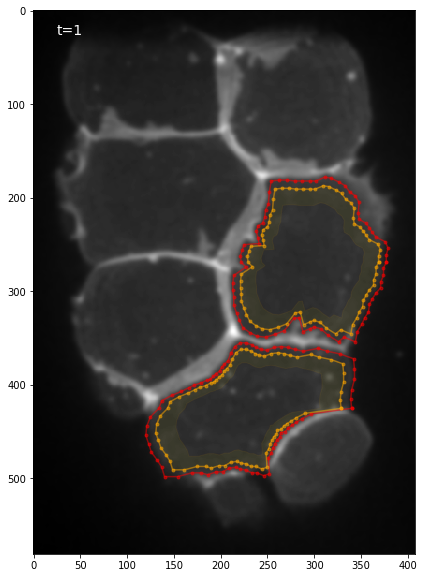

In [26]:
def plot_coords(ax, poly, c, style='.-', alpha=.5):
    x, y = poly.xy
    ax.plot(x, y, style, color=c, alpha=alpha, zorder=1)

t = 1
fig = plt.figure()
ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax.imshow(segchannel_smooth[t], plt.get_cmap('gray'))
ax.text(25, 25, 't=%d'%t, fontsize=14, color='w')

for obj in objects:
    
    poly_membrane = geometry.Polygon(membrane_polygones_per_object[obj][t])
    poly_membrane2 = geometry.Polygon(annulus_outer_polygones_per_object[obj][t])
    poly_annulus = geometry.Polygon(annulus_outer_polygones_per_object[obj][t], [annulus_inner_polygones_per_object[obj][t][::-1]])
    patch_annulus = PolygonPatch(poly_annulus, facecolor='#%02x%02x%02x'%(219,209,0), edgecolor='orange', alpha=0.0625, zorder=2)
    ax.add_patch(patch_annulus)
    plot_coords( ax, poly_membrane.exterior, 'red', alpha=.5 )
    plot_coords( ax, poly_membrane2.exterior, 'orange', alpha=.5 )
    

In [27]:
def get_annulus_bresenham_lines(inner_polygone, outer_polygone):
    annulus_bresenham_lines = []
    for i in range(len(inner_polygone)):
        points = bham.bresenhamline( np.array([inner_polygone[i]]),np.array([outer_polygone[i]]) )
        annulus_bresenham_lines.append(points)
    return annulus_bresenham_lines

In [28]:
annulus_bresenham_lines_per_frame_per_object = []
for obj in objects:
    annulus_bresenham_lines_per_frame = []
    for t in range(T):
        annulus_bresenham_lines = get_annulus_bresenham_lines( annulus_inner_polygones_per_object[obj][t], annulus_outer_polygones_per_object[obj][t] )
        annulus_bresenham_lines_per_frame.append( annulus_bresenham_lines )
    annulus_bresenham_lines_per_frame_per_object.append( annulus_bresenham_lines_per_frame )

### compute membrane movement vectors

In [29]:
membrane_movement_vectors_per_frame_per_object = []
for obj in objects:

    membrane_movement_vectors_per_frame = []
    for t in range(T):
        membrane_movement_vectors = []

        poly_t1 = membrane_polygones_per_object[obj][t]
        poly_t2 = membrane_polygones_per_object[obj][t+1]
        
        for i in range(len(poly_t2)):
            p1 = [poly_t1[i][0] , poly_t1[i][1]]
            p2 = [poly_t2[i][0] , poly_t2[i][1]]
            membrane_movement_vectors.append( [p2[0]-p1[0] , p2[1]-p1[1]] )
        membrane_movement_vectors_per_frame.append( membrane_movement_vectors )
    membrane_movement_vectors_per_frame_per_object.append( membrane_movement_vectors_per_frame )

### compute averaged flow vectors

In [30]:
annulus_avg_flow_vectors_per_frame_per_object = []
for obj in objects:
    annulus_avg_flow_vectors_per_frame = []
    for t in range(T):
        annulus_avg_flow_vectors = []
        lines = annulus_bresenham_lines_per_frame_per_object[obj][t]
        for l, line in enumerate(lines):
            sum_x = 0.0
            sum_y = 0.0
            for point in line:
                sum_x += avg_flow_x[t,int (point[1]),int(point[0])]
                sum_y += avg_flow_y[t,int(point[1]),int(point[0])]
            avg_x = sum_x / len(line)
            avg_y = sum_y / len(line)
            annulus_avg_flow_vectors.append([avg_x,avg_y])
        annulus_avg_flow_vectors_per_frame.append(annulus_avg_flow_vectors)
    annulus_avg_flow_vectors_per_frame_per_object.append( annulus_avg_flow_vectors_per_frame )

### compute projected vector lengths

In [31]:
column_vectors = col_vectors # they are normalized to length 1

In [32]:
projected_avg_flows_per_frame_per_object = []
projected_mem_vecs_per_frame_per_object = []
for obj in objects:
    projected_avg_flows_per_frame = []
    projected_mem_vecs_per_frame = []
    for t in range(T):
        projected_avg_flows = []
        projected_mem_vecs = []
        for i in range(len(column_vectors)):
            projected_avg_flows.append( bsu.get_projected_length(annulus_avg_flow_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
            projected_mem_vecs.append( bsu.get_projected_length(membrane_movement_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
        projected_avg_flows_per_frame.append( projected_avg_flows )
        projected_mem_vecs_per_frame.append( projected_mem_vecs )
    projected_avg_flows_per_frame_per_object.append( projected_avg_flows_per_frame )
    projected_mem_vecs_per_frame_per_object.append( projected_mem_vecs_per_frame )

### compute frame averages and correlations for lineplots

In [33]:
avg_membrane_contraction_per_frame_per_object = []
avg_center_flow_per_frame_per_object = []
correlation_per_frame_per_object = []
slippage_per_frame_per_object = []
for obj in objects:
    avg_membrane_contraction_per_frame = []
    avg_center_flow_per_frame = []
    correlation_per_frame = []
    slippage_per_frame = []
    for t in range(T):
        memveclengths=projected_mem_vecs_per_frame_per_object[obj][t]
        flowveclengths=projected_avg_flows_per_frame_per_object[obj][t]
        
        avg_membrane_contraction_per_frame.append( np.mean(memveclengths) )
        avg_center_flow_per_frame.append( np.mean( flowveclengths) )
        correlation_per_frame.append( pearsonr(memveclengths, flowveclengths)[0] )
        
        slippage_per_frame.append( np.mean(flowveclengths) - np.mean(memveclengths) )
                
    avg_membrane_contraction_per_frame_per_object.append( avg_membrane_contraction_per_frame )
    avg_center_flow_per_frame_per_object.append( avg_center_flow_per_frame )
    correlation_per_frame_per_object.append( correlation_per_frame )
    slippage_per_frame_per_object.append( slippage_per_frame )

# Plotting crunched flow data

In [34]:
def plot_coords(ax, poly, c, style='.-', alpha=.5):
    x, y = poly.xy
    ax.plot(x, y, style, color=c, alpha=alpha, zorder=1)

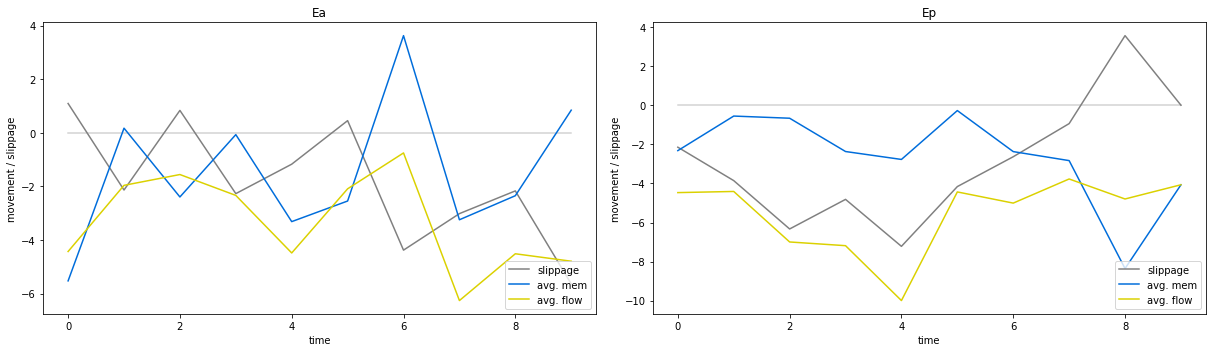

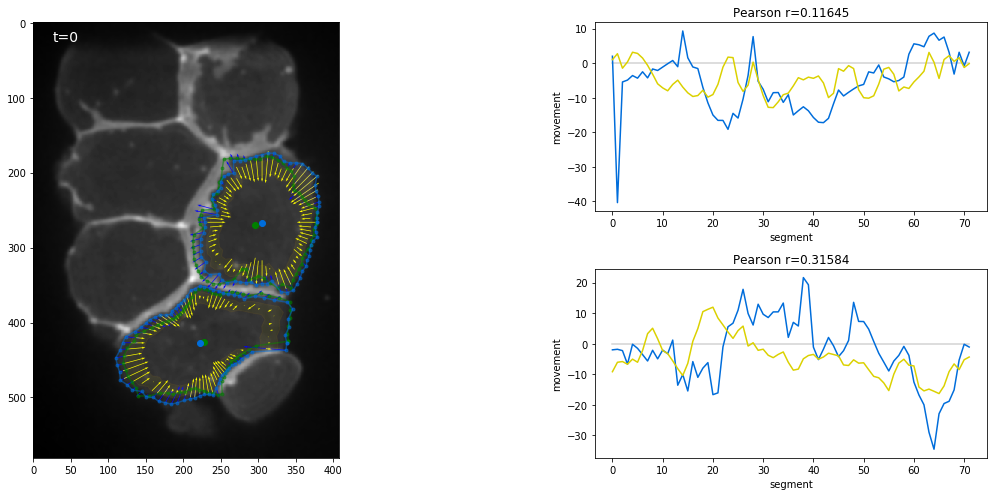

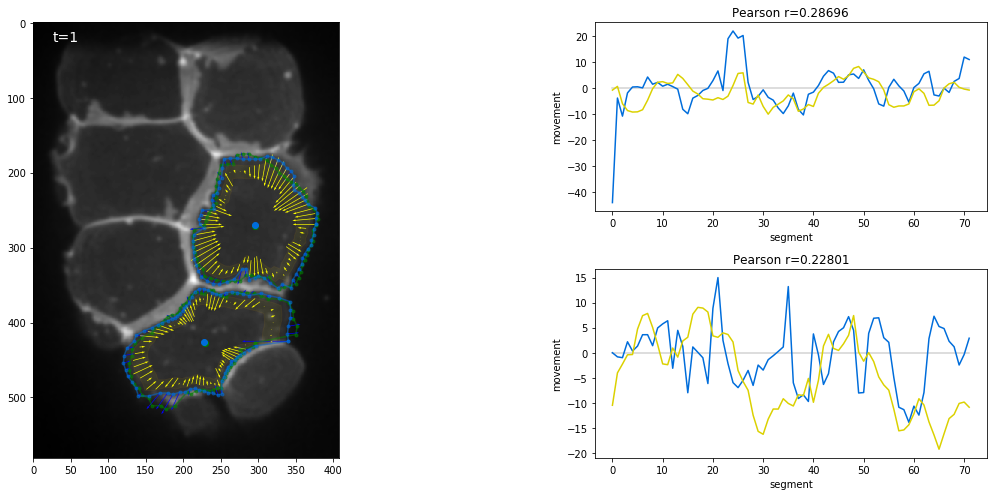

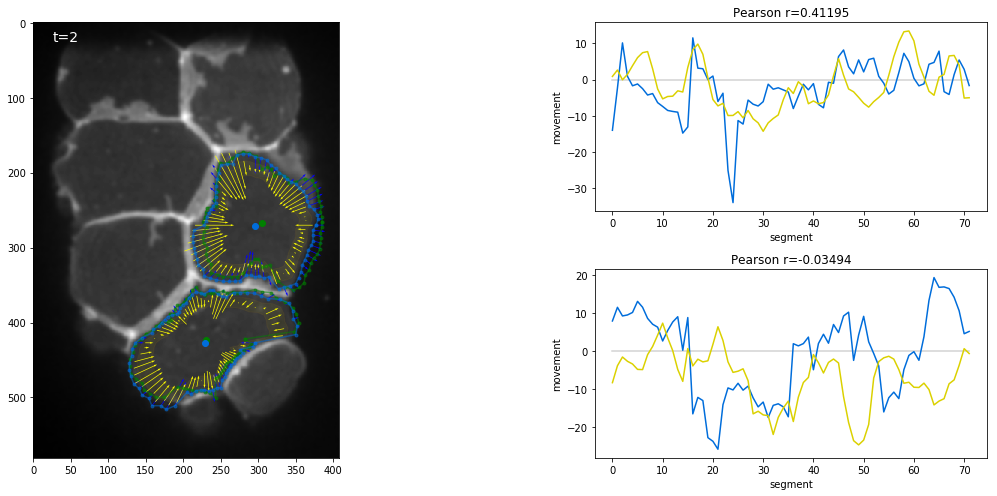

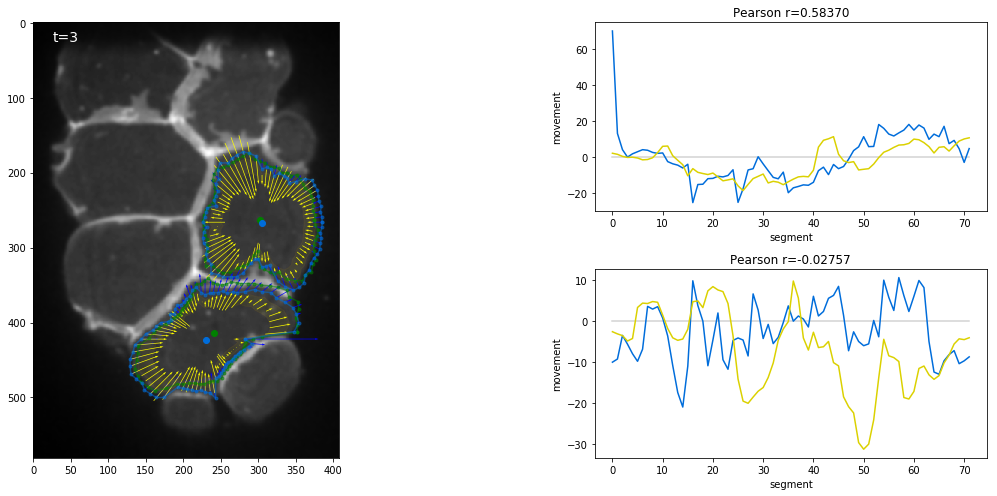

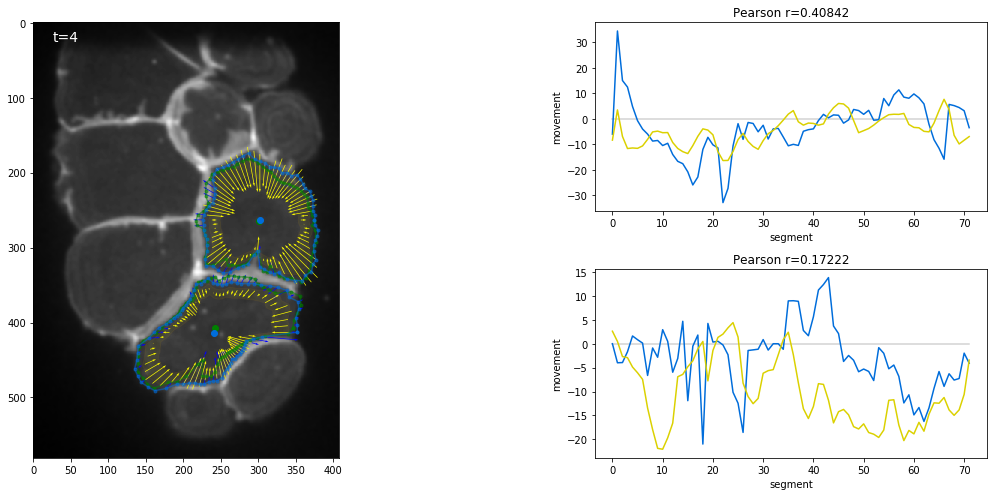

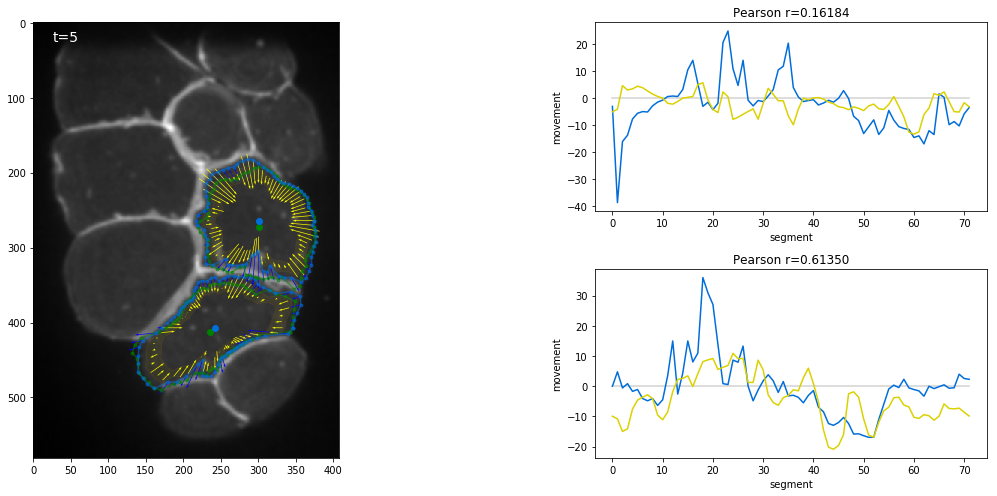

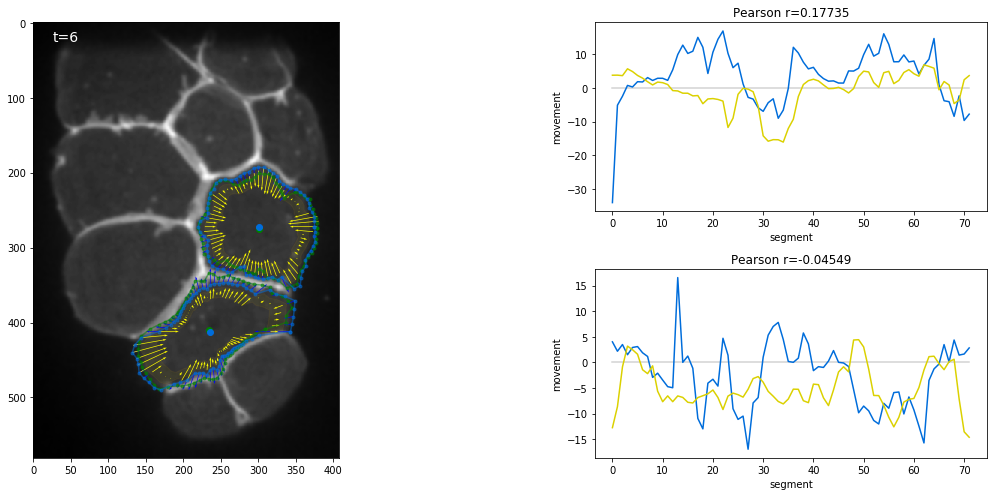

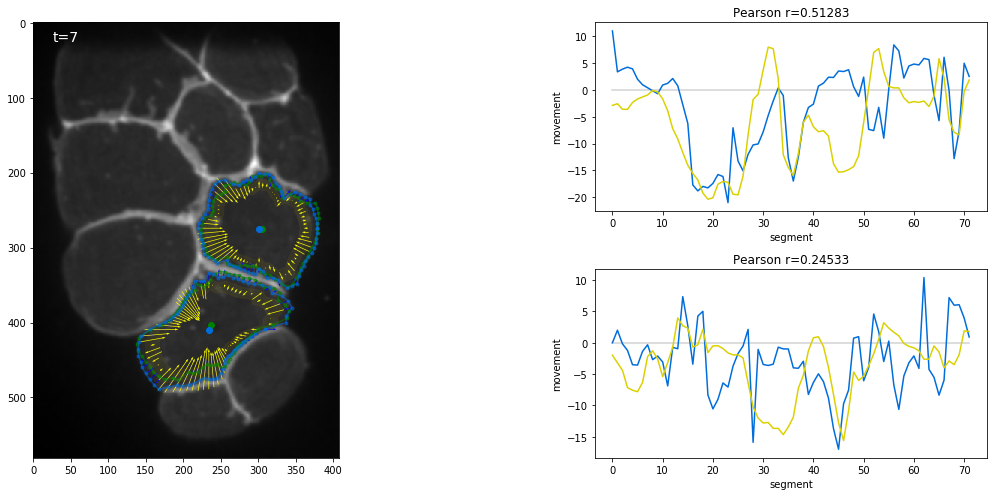

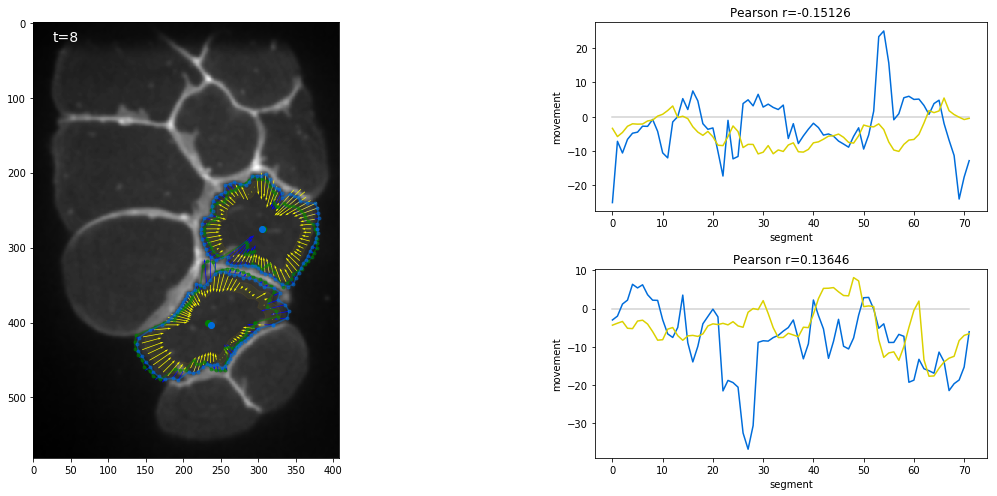

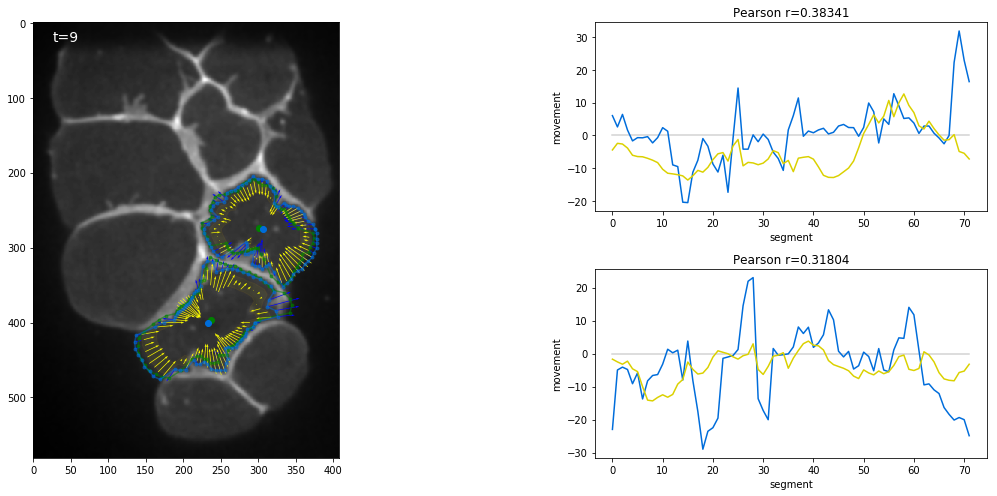

In [35]:
pylab.rcParams['figure.figsize'] = (17, 5)
fig = plt.figure()
ax = plt.subplot(121)
ax.set_title(data.object_names[0])
ax.set_xlabel('time')
ax.set_ylabel('movement / slippage')
ax.plot(np.zeros_like(correlation_per_frame_per_object[0]), color='lightgray')
ax.plot(slippage_per_frame_per_object[0], color='gray', label='slippage')
ax.plot(avg_membrane_contraction_per_frame_per_object[0], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
ax.plot(avg_center_flow_per_frame_per_object[0], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
ax = plt.subplot(122)

ax.set_title(data.object_names[1])
ax.set_xlabel('time')
ax.set_ylabel('movement / slippage')
ax.plot(np.zeros_like(correlation_per_frame_per_object[1]), color='lightgray')
ax.plot(slippage_per_frame_per_object[1], color='gray', label='slippage')
ax.plot(avg_membrane_contraction_per_frame_per_object[1], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
ax.plot(avg_center_flow_per_frame_per_object[1], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
fig.tight_layout()

pylab.rcParams['figure.figsize'] = (17, 7)
offset = 0
stepsize = 2
show_projected = True

for t in range(0,len(segchannel)-1,1):
    fig = plt.figure()
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax2 = plt.subplot(233)
    ax3 = plt.subplot(236)

    ax.imshow(segchannel_smooth[t], plt.get_cmap('gray'))
    ax.text(25, 25, 't=%d'%t, fontsize=14, color='w')

    for obj in objects:
        # center points
        ax.plot(query_centroids[obj][t+1][1],query_centroids[obj][t+1][0], 'o', color='green')
        ax.plot(query_centroids[obj][t][1],query_centroids[obj][t][0], 'o', color='#%02x%02x%02x'%(0,109,219))
        
        # polygones (membrane and annulus)
        poly_membrane = geometry.Polygon(membrane_polygones_per_object[obj][t])
        poly_membrane_t2 = geometry.Polygon(membrane_polygones_per_object[obj][t+1])
        poly_annulus = geometry.Polygon(annulus_outer_polygones_per_object[obj][t], [annulus_inner_polygones_per_object[obj][t][::-1]])
        poly_annulus_middle = geometry.Polygon(annulus_middle_polygones_per_object[obj][t])

        plot_coords( ax, poly_membrane_t2.exterior, 'green', alpha=.5 )
        plot_coords( ax, poly_membrane.exterior, '#%02x%02x%02x'%(0,109,219) )

        patch_annulus = PolygonPatch(poly_annulus, facecolor='#%02x%02x%02x'%(219,209,0), edgecolor='orange', alpha=0.0625, zorder=2)
        ax.add_patch(patch_annulus)

         # membrane quivers
        mem_base_x = [p[0] for p in membrane_polygones_per_object[obj][t]]
        mem_base_y = [p[1] for p in membrane_polygones_per_object[obj][t]]
        if (show_projected):
            mem_vec = [column_vectors[i]*projected_mem_vecs_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            mem_vec_x = [v[0] for v in mem_vec]
            mem_vec_y = [-v[1] for v in mem_vec]
        else:
            mem_vec_x = [v[0] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
            mem_vec_y = [-v[1] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
        ax.quiver(mem_base_x, 
                  mem_base_y, 
                  mem_vec_x, 
                  mem_vec_y, 
                  width=0.0022, scale=flowchannel.shape[1]/2., color='blue')
        
        # flow quivers
        flow_base_x = [p[0] for p in annulus_middle_polygones_per_object[obj][t]]
        flow_base_y = [p[1] for p in annulus_middle_polygones_per_object[obj][t]]
        if (show_projected):
            flow_vec = [column_vectors[i]*projected_avg_flows_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            flow_vec_x = [v[0] for v in flow_vec]
            flow_vec_y = [-v[1] for v in flow_vec]
        else:
            flow_vec_x = [v[0] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
            flow_vec_y = [-v[1] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
        ax.quiver(flow_base_x, 
                  flow_base_y, 
                  flow_vec_x, 
                  flow_vec_y, 
                  pivot='mid', width=0.0022, scale=flowchannel.shape[1]/4., color='yellow')
        
        
#     LINEPLOT
#     ========
    ax2.set_title('Pearson r=%.5f'%correlation_per_frame_per_object[0][t])
    ax2.set_xlabel('segment')
    ax2.set_ylabel('movement')
    ax2.plot(np.zeros_like(projected_mem_vecs_per_frame_per_object[0][t]), color='lightgray')
    ax2.plot(projected_mem_vecs_per_frame_per_object[0][t], color='#%02x%02x%02x'%(0,109,219))
    ax2.plot(projected_avg_flows_per_frame_per_object[0][t], color='#%02x%02x%02x'%(219,209,0))
    
    ax3.set_title('Pearson r=%.5f'%correlation_per_frame_per_object[1][t])
    ax3.set_xlabel('segment')
    ax3.set_ylabel('movement')
    ax3.plot(np.zeros_like(projected_mem_vecs_per_frame_per_object[1][t]), color='lightgray')
    ax3.plot(projected_mem_vecs_per_frame_per_object[1][t], color='#%02x%02x%02x'%(0,109,219))
    ax3.plot(projected_avg_flows_per_frame_per_object[1][t], color='#%02x%02x%02x'%(219,209,0))


    fig.tight_layout()

In [37]:
projected_avg_flows_per_frame_per_object[1][3][60:62]

[-17.138484383757596, -11.53264038126337]

In [38]:
projected_mem_vecs_per_frame_per_object[1][3][60:62]

[6.062177826491073, 9.912249751943056]